In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, Activation
from tensorflow.keras.layers import UpSampling2D, add, ZeroPadding2D, PReLU, Cropping2D, BatchNormalization
from tensorflow.keras.layers import LeakyReLU, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence, OrderedEnqueuer
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from keras.applications import VGG19
from keras.applications.vgg19 import preprocess_input
from tensorflow.keras import activations
from tensorflow.keras.layers.experimental.preprocessing import Resizing
import keras.backend as K

import os
import sys
import datetime
import re
from scipy import ndimage, misc
from skimage.transform import resize, rescale
from matplotlib import pyplot
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random

devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(devices[0], True)
#tf.keras.backend.set_floatx('float16')

## Hyperparamters

In [2]:
height_lr = 68
width_lr = 90
channels = 3
shape_lr = (height_lr, width_lr, channels)
shape_hr = (4*height_lr, 4*width_lr, channels)
data_num = 7
data_dir = f"../../datasets/dataset_0{data_num}/"

activation = 'relu'
regularizer = regularizers.l1(1e-9)
dropout_ratio = 0.25
batch_size = 4
epochs = 50_000

learning_rate = 0.0005
gen_lr = 1e-4
dis_lr = 1e-4
optimizer = Adam(0.0002, 0.5)
loss_weights=[1e-3, 0.006]
gan_loss = 'mse'
dis_loss = 'binary_crossentropy'

n_residual_blocks=16
filters=64
gf = 64
df = 64

patch = int((height_lr*4) / 2**4)
disc_patch = (patch, patch, 1)

## Helper Functions

## Data

In [3]:
class DataLoader(Sequence):
    def __init__(self, list_IDs, batch_size=4):
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.on_epoch_end()

    @staticmethod
    def scale_lr_imgs(imgs):
        """Scale low-res images prior to passing to SRGAN"""
        return imgs / 255.
    
    @staticmethod
    def unscale_lr_imgs(imgs):
        """Un-Scale low-res images"""
        return imgs * 255
    
    @staticmethod
    def scale_hr_imgs(imgs):
        """Scale high-res images prior to passing to SRGAN"""
        return imgs / 127.5 - 1
    
    @staticmethod
    def unscale_hr_imgs(imgs):
        """Un-Scale high-res images"""
        return (imgs + 1.) * 127.5
    
    @staticmethod
    def load_img(path):
        img = Image.open(path)
        if img.mode != 'RGB':
            img = img.convert('RGB')
        return np.array(img)
    
    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        #print(f'Batch index: {index}')
        indexes = []
        for i in range(index*self.batch_size, (index+1)*self.batch_size):
            indexes.append(i)

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        return 0

    def __data_generation(self, list_IDs_temp):
        imgs_hr = []
        imgs_lr = []
        for i, filename in enumerate(list_IDs_temp):
            if re.search("\.(jpg|jpeg)", filename):
                filepath = os.path.join(data_dir+'full', filename)
                image_hr = self.load_img(filepath)
                filepath = os.path.join(data_dir+'quarter', filename)
                image_lr = self.load_img(filepath)
                if len(image_hr.shape) > 2 and len(image_lr.shape) > 2:
                    #Y.append(resize(image_y, (self.dim[0], self.dim[1]+8)))
                    imgs_hr.append(image_hr)
                    imgs_lr.append(image_lr)
                    
        imgs_hr = self.scale_hr_imgs(np.array(imgs_hr))
        imgs_lr = self.scale_lr_imgs(np.array(imgs_lr))
        #print(f'Length of X: {len(X)}')
        return imgs_lr, imgs_hr   

## Models

### VGG

In [4]:
img_vgg = Input(shape=shape_hr)
vgg = VGG19(weights="imagenet", include_top=False, input_tensor=img_vgg)
vgg = Model(inputs=vgg.input, outputs=vgg.layers[9].output)
vgg.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 272, 360, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 272, 360, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 272, 360, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 136, 180, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 136, 180, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 136, 180, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 68, 90, 128)       0     

### Generator

In [5]:
def residual_block(layer_input, filters):
    d = Conv2D(filters, kernel_size=3, strides=1, padding='same')(layer_input)
    d = Activation('relu')(d)
    d = BatchNormalization(momentum=0.8)(d)
    d = Conv2D(filters, kernel_size=3, strides=1, padding='same')(d)
    d = BatchNormalization(momentum=0.8)(d)
    d = add([d, layer_input])
    return d

def deconv2d(layer_input):
    u = UpSampling2D(size=2)(layer_input)
    u = Conv2D(256, kernel_size=3, strides=1, padding='same')(u)
    u = Activation('relu')(u)
    return u

# Low resolution image input
img_gen = Input(shape=shape_lr)
# Pre-residual block
c1 = Conv2D(64, kernel_size=9, strides=1, padding='same')(img_gen)
c1 = Activation('relu')(c1)
# Propogate through residual blocks
r = residual_block(c1, gf)
for _ in range(n_residual_blocks - 1):
    r = residual_block(r, gf)
# Post-residual block
c2 = Conv2D(64, kernel_size=3, strides=1, padding='same')(r)
c2 = BatchNormalization(momentum=0.8)(c2)
c2 = add([c2, c1])
# Upsampling
u1 = deconv2d(c2)
u2 = deconv2d(u1)
# Generate high resolution output
gen_hr = Conv2D(channels, kernel_size=9, strides=1, padding='same', activation='tanh')(u2)
generator = Model(img_gen, gen_hr)
generator.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 68, 90, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 68, 90, 64)   15616       input_2[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 68, 90, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 68, 90, 64)   36928       activation[0][0]                 
____________________________________________________________________________________________

### Discriminator

In [6]:
def d_block(layer_input, filters, strides=1, bn=True):
    d = Conv2D(filters, kernel_size=3, strides=strides, padding='same')(layer_input)
    d = LeakyReLU(alpha=0.2)(d)
    if bn:
        d = BatchNormalization(momentum=0.8)(d)
    return d

# Input img
d0 = Input(shape=shape_hr)
d1 = d_block(d0, df, bn=False)
d2 = d_block(d1, df, strides=2)
d3 = d_block(d2, df*2)
d4 = d_block(d3, df*2, strides=2)
d5 = d_block(d4, df*4)
d6 = d_block(d5, df*4, strides=2)
d7 = d_block(d6, df*8)
d8 = d_block(d7, df*8, strides=2)
d9 = Dense(df*16)(d8)
d10 = LeakyReLU(alpha=0.2)(d9)
validity = Dense(1, activation='sigmoid')(d10)
discriminator = Model(d0, validity)
discriminator.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 272, 360, 3)]     0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 272, 360, 64)      1792      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 272, 360, 64)      0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 136, 180, 64)      36928     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 136, 180, 64)      0         
_________________________________________________________________
batch_normalization_33 (Batc (None, 136, 180, 64)      256       
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 136, 180, 128)     7385

### SRGAN

In [7]:
vgg.trainable = False
vgg.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])

discriminator.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])

img_hr = Input(shape=shape_hr)
img_lr = Input(shape=shape_lr)

fake_hr = generator(img_lr)
fake_features = vgg(fake_hr)
discriminator.trainable = False
validity = discriminator(fake_hr)

srgan = Model([img_lr, img_hr], [validity, fake_features])
srgan.compile(loss=['binary_crossentropy', 'mse'],
                              loss_weights=[1e-3, 1],
                              optimizer=optimizer)
srgan.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 68, 90, 3)]  0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 272, 360, 3)  2042691     input_5[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 272, 360, 3) 0                                            
__________________________________________________________________________________________________
model_2 (Model)                 (None, 17, 23, 1)    5219137     model_1[1][0]                    
____________________________________________________________________________________________

## Training

In [9]:
print_frequency = 20

loader = DataLoader(os.listdir(data_dir+'full'), batch_size=batch_size)
enqueuer = OrderedEnqueuer(loader, use_multiprocessing=True, shuffle=True)
enqueuer.start(workers=6, max_queue_size=12)
output_generator = enqueuer.get()

disciminator_output_shape = list(discriminator.output_shape)
disciminator_output_shape[0] = batch_size
disciminator_output_shape = tuple(disciminator_output_shape)

valid = np.ones(disciminator_output_shape)
fake = np.zeros(disciminator_output_shape)

print(disciminator_output_shape)
start_time = datetime.datetime.now()
for epoch in range(epochs):
    if (epoch-1) % (print_frequency) == 0:
        start_time = datetime.datetime.now()

    imgs_lr, imgs_hr = next(output_generator)
    fake_hr = generator.predict(imgs_lr)

    

    d_loss_real = discriminator.train_on_batch(imgs_hr, valid)
    d_loss_fake = discriminator.train_on_batch(fake_hr, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    image_features = vgg.predict(imgs_hr)
    g_loss = srgan.train_on_batch([imgs_lr, imgs_hr], [valid, image_features])

    elapsed_time = (datetime.datetime.now() - start_time).seconds
    # Plot the progress
    if epoch % print_frequency == 0:
        print ("%d time: %s" % (epoch, elapsed_time) + f"\nG Loss: {g_loss}\nD Loss: {d_loss}")

44]
D Loss: [1.31747992e-04 1.00000000e+00]
8500 time: 5604
G Loss: [3.848997116088867, 4.46768045425415, 3.844529390335083]
D Loss: [1.01756686e-04 1.00000000e+00]
8520 time: 5618
G Loss: [1.9984670877456665, 4.028958320617676, 1.9944381713867188]
D Loss: [0.00159298 1.        ]
8540 time: 5632
G Loss: [2.0995051860809326, 1.8210843801498413, 2.097684144973755]
D Loss: [0.00350497 0.99968031]
8560 time: 5645
G Loss: [2.404694080352783, 2.3213534355163574, 2.4023728370666504]
D Loss: [8.55744816e-04 1.00000000e+00]
8580 time: 5658
G Loss: [2.772488832473755, 3.062359094619751, 2.7694265842437744]
D Loss: [0.0016265 1.       ]
8600 time: 5671
G Loss: [3.857490301132202, 3.6453566551208496, 3.8538448810577393]
D Loss: [1.34927068e-04 1.00000000e+00]
8620 time: 5684
G Loss: [2.347801446914673, 2.8574140071868896, 2.3449440002441406]
D Loss: [5.58306248e-04 1.00000000e+00]
8640 time: 5697
G Loss: [2.540114164352417, 3.843731164932251, 2.5362703800201416]
D Loss: [3.34304932e-04 1.00000000e

KeyboardInterrupt: 

## Results

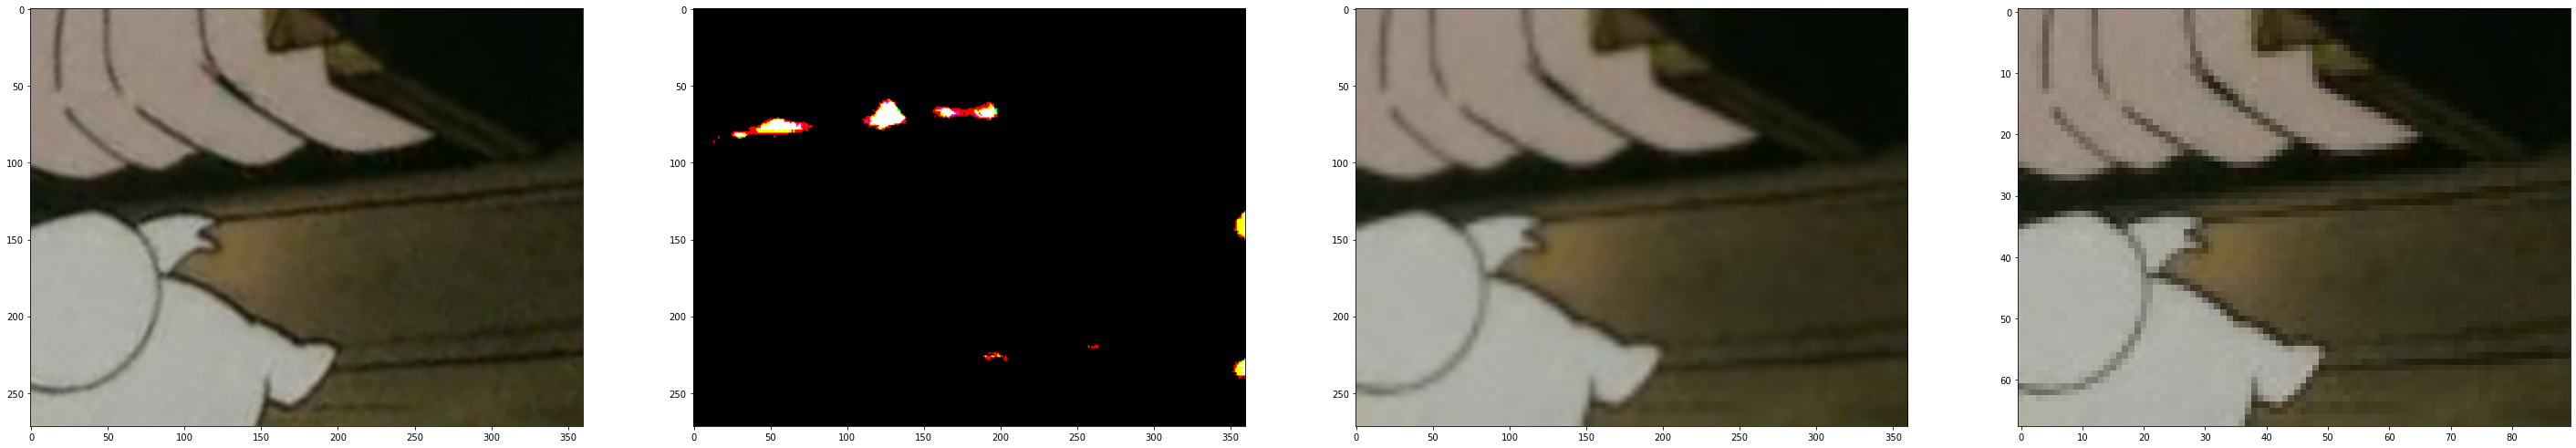

In [14]:
random_names = os.listdir(data_dir+'full')
image_name = random_names[random.randint(0, len(random_names))]
full_image = pyplot.imread(os.path.join(data_dir+'full', image_name))
quarter_image = pyplot.imread(os.path.join(data_dir+'quarter', image_name))
#print(quarter_image[:3,:3,:])
pred_image = DataLoader.scale_lr_imgs(quarter_image)
#print(pred_image[:3,:3,:])
pred_image = np.expand_dims(quarter_image, 0)
pred_image = generator.predict(pred_image)[0]
#print(pred_image[:3,:3,:])
pred_image = DataLoader.unscale_hr_imgs(pred_image)
#print(pred_image[:3,:3,:])
pred_image = np.array(pred_image).astype(np.uint8)
#print(pred_image[:3,:3,:])
plt.figure(figsize=(128, 128))
ax = plt.subplot(10, 10, 1)
plt.imshow(full_image)
ax = plt.subplot(10, 10, 2)
plt.imshow(pred_image)
ax = plt.subplot(10, 10, 3)
plt.imshow(resize(quarter_image, (shape_hr[0], shape_hr[1])))
ax = plt.subplot(10, 10, 4)
plt.imshow(quarter_image)